## [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [96]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
def plot_losses(losses):
  import matplotlib.pyplot as plt
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

### Micrograd Classes and Functions

In [98]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [99]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [100]:
import random

class Neuron:
    
    def __init__(self, nin):
#### my add ##########################################        
        # random.seed(12345)  # WARNING: all neurons will have the same weights and bias
######################################################        
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

### Neuron in Neural Network
<!-- ### Simple Neural Network: Single Neuron with 3 Inputs -->
<img src="..\karpathy\img\Nertual_Network_1_Neuron_3_Inputs.png">

#### Activation Function: Tanh

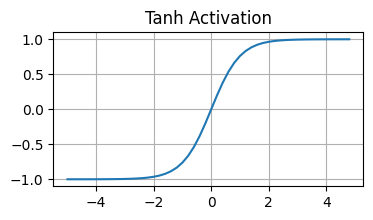

In [101]:
_num = np.arange(-5, 5, 0.2)
plt.figure(figsize=(4, 2))
plt.plot(_num, np.tanh(_num))
plt.title("Tanh Activation")
plt.grid()

##### Calculate Output with Forward Pass

In [102]:
# inputs
x0 = Value(-3.0, label='x0')
x1 = Value(0.0, label='x1')
x2 = Value(0.5, label='x2')

# weights
w0 = Value(2.0, label='w0')
w1 = Value(1.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(4.618626415, label='b')

# forward pass
# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_0 = n.tanh(); out_0.label = 'out_0'
print(f'neuron output: {out_0.data}')

neuron output: -0.7071067801767762


##### Calculate Gradient with Backward Pass

w0.grad(i.e. d(output)/d(w0)): -1.500000004284097


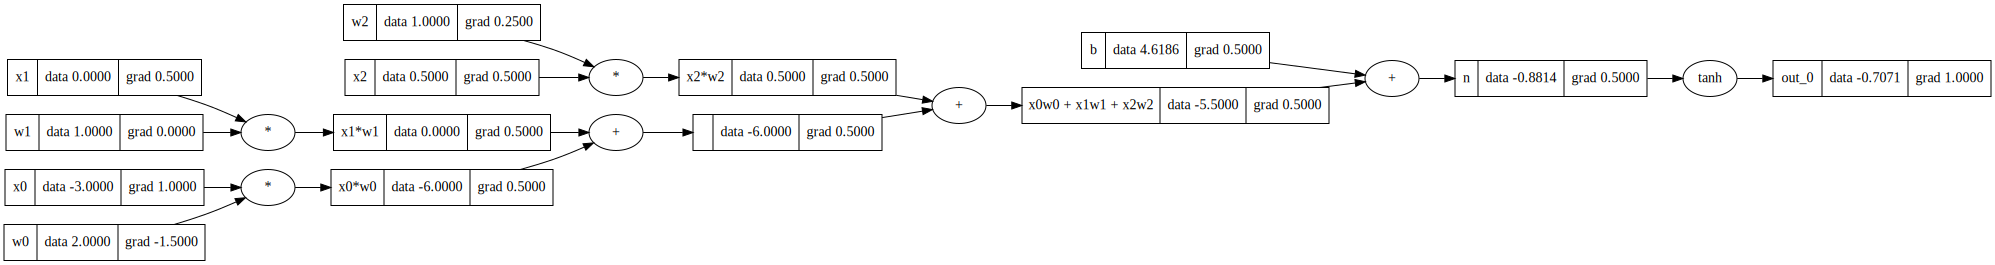

In [103]:
# backward pass to calculate gradient
out_0.backward()
  
out_0_grad = w0.grad  # store w0.grad, further calculation with w0 will reset w0.grad to zero
print(f'w0.grad(i.e. d(output)/d(w0)): {w0.grad}')
draw_dot(out_0)

##### Check Backward Pass Gradient Calculation: d(output) / d(x0)

In [104]:
h = 0.000001
w0 += h  # increment x0 by h

# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_1 = n.tanh(); out_1.label = 'out_1'
out_grad = (out_1 - out_0) / h 

print(f'---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----')
print(f'out_1: {out_1.data:<12.10f}, out_0: {out_0.data:<12.10f}, d(out): {out_1.data-out_0.data:<12.10f}, d(w0): {h:<12.10f}, d(out)/d(w0): {(out_1.data-out_0.data)/h:<12.10f}')
print(f'd(out) / d(w0):             {out_grad.data:<12.10f}')
print(f'w0.grad from backward pass: {out_0_grad:<12.10f}')

---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----
out_1: -0.7071082802, out_0: -0.7071067802, d(out): -0.0000015000, d(w0): 0.0000010000, d(out)/d(w0): -1.4999968224
d(out) / d(w0):             -1.4999968224
w0.grad from backward pass: -1.5000000043


##### Check Output and Gradient Calculation with PyTorch

In [105]:
import torch

In [106]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <--')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <--')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <--
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <--


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [107]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [108]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'len(n.parameters()): {len(n.parameters())}')
# n.parameters()
for i, v in enumerate(n.parameters()):
  print(f'i: {i:>2}, {v.data:>14.10f}')

len(n.parameters()): 41
i:  0,  -0.9832876907
i:  1,  -0.7234887384
i:  2,   0.1456910033
i:  3,  -0.9995106530
i:  4,   0.4330789096
i:  5,   0.2660471876
i:  6,  -0.8543004990
i:  7,  -0.2030558814
i:  8,  -0.5170396351
i:  9,  -0.9333212441
i: 10,   0.7356234173
i: 11,   0.3583629731
i: 12,  -0.3006280096
i: 13,  -0.5951220749
i: 14,   0.9348408476
i: 15,  -0.0438233602
i: 16,   0.4041651256
i: 17,  -0.2382886990
i: 18,   0.5155035880
i: 19,   0.6465018217
i: 20,   0.6388858994
i: 21,   0.1339198059
i: 22,   0.9387308056
i: 23,  -0.3369555288
i: 24,   0.6984678226
i: 25,   0.8475099692
i: 26,  -0.2737465845
i: 27,   0.4701694654
i: 28,   0.1517793505
i: 29,   0.8783187342
i: 30,  -0.5329434964
i: 31,  -0.7309080575
i: 32,  -0.6172468751
i: 33,   0.6218843268
i: 34,  -0.8274923426
i: 35,   0.3658998393
i: 36,  -0.2105160705
i: 37,  -0.9261558980
i: 38,   0.4566659632
i: 39,  -0.3383475404
i: 40,   0.7381839177


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [109]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [110]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}')
        print(f'b_mat:  {b_mat}')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('----')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
neuron 0
w0: -0.9832877,   w0.grad:  0.0000000
w1: -0.7234887,   w1.grad:  0.0000000
w2:  0.1456910,   w2.grad:  0.0000000
b:  -0.9995107
b_mat:  [-0.9995106530316995]
neuron 1
w0:  0.4330789,   w0.grad:  0.0000000
w1:  0.2660472,   w1.grad:  0.0000000
w2: -0.8543005,   w2.grad:  0.0000000
b:  -0.2030559
b_mat:  [-0.9995106530316995, -0.20305588135101393]
neuron 2
w0: -0.5170396,   w0.grad:  0.0000000
w1: -0.9333212,   w1.grad:  0.0000000
w2:  0.7356234,   w2.grad:  0.0000000
b:   0.3583630
b_mat:  [-0.9995106530316995, -0.20305588135101393, 0.35836297305725595]
neuron 3
w0: -0.3006280,   w0.grad:  0.0000000
w1: -0.5951221,   w1.grad:  0.0000000
w2:  0.9348408,   w2.grad:  0.0000000
b:  -0.0438234
b_mat:  [-0.9995106530316995, -0.20305588135101393, 0.35836297305725595, -0.04382336023079447]
----
layer: 1, neuron_cnt: 4
----
neuron 0
w0:  0.4041651,   w0.grad:  0.0000000
w1: -0.2382887,   w1.grad:  0.0000000
w2:  0.5155036,   w2.grad:  0.000000

##### Print Neural Network's Weights and Biases Matrices

In [111]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat:\n{w_n_b[0]}')
  print(f'b_mat:\n{w_n_b[1]}\n')  
    

i: 0
w_mat:
[[-0.98328769 -0.72348874  0.145691  ]
 [ 0.43307891  0.26604719 -0.8543005 ]
 [-0.51703964 -0.93332124  0.73562342]
 [-0.30062801 -0.59512207  0.93484085]]
b_mat:
[[-0.99951065 -0.20305588  0.35836297 -0.04382336]]

i: 1
w_mat:
[[ 0.40416513 -0.2382887   0.51550359  0.64650182]
 [ 0.13391981  0.93873081 -0.33695553  0.69846782]
 [-0.27374658  0.47016947  0.15177935  0.87831873]
 [-0.73090806 -0.61724688  0.62188433 -0.82749234]]
b_mat:
[[ 0.6388859   0.84750997 -0.5329435   0.36589984]]

i: 2
w_mat:
[[-0.21051607 -0.9261559   0.45666596 -0.33834754]]
b_mat:
[[0.73818392]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [112]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])
  output = np.tanh(np.matmul(weights, input) + bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')    
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[-0.98328769 -0.72348874  0.145691  ]
 [ 0.43307891  0.26604719 -0.8543005 ]
 [-0.51703964 -0.93332124  0.73562342]
 [-0.30062801 -0.59512207  0.93484085]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

bias (4, 1):
[[-0.99951065]
 [-0.20305588]
 [ 0.35836297]
 [-0.04382336]]

output (4, 2):
[[-0.99994837 -0.9963563 ]
 [ 0.98069976  0.38249879]
 [-0.99956042  0.10795469]
 [-0.99761515  0.11630638]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[ 0.40416513 -0.2382887   0.51550359  0.64650182]
 [ 0.13391981  0.93873081 -0.33695553  0.69846782]
 [-0.27374658  0.47016947  0.15177935  0.87831873]
 [-0.73090806 -0.61724688  0.62188433 -0.82749234]]

input (4, 2):
[[-0.99994837 -0.9963563 ]
 [ 0.98069976  0.38249879]
 [-0.99956042  0.10795469]
 [-0.99761515  0.11630638]]

bias (4, 1):
[[ 0.6388859 ]
 [ 0.84750997]
 [-0.5329435 ]
 [ 0.36589984]]

output (4, 2):
[[-0.82077411  

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [113]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [-0.3748871675764406, -0.2713972074342068]
ys:                 [1.0, -1.0]
loss_data:          2.4211767529010393


#### Micrograd backward pass and update parameters

In [114]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0     -0.9832876907    -0.0033739380           0.05000        -0.9831189938
  1     -0.7234887384     0.0010984909           0.05000        -0.7235436630
  2      0.1456910033    -0.0005528120           0.05000         0.1457186439
  3     -0.9995106530    -0.0011270237           0.05000        -0.9994543018
  4      0.4330789096     0.2357398752           0.05000         0.4212919159
  5      0.2660471876    -0.0890618719           0.05000         0.2705002812
  6     -0.8543004990     0.0431015841           0.05000        -0.8564555782
  7     -0.2030558814     0.0776270572           0.05000        -0.2069372342
  8     -0.5170396351    -0.1426715804           0.05000        -0.5099060561
  9     -0.9333212441     0.0479253242           0.05000        -0.9357175103
 10      0.7356234173    -0.0239124625           0.05000         0.7368190404
 11      0.3583629731    -0.0475237270

### Improve Prediction with Parameter Iteration 

In [115]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = -0.07307451579437767), Value(data = -0.20052644490153435)]
step: 0, loss: 1.7906468817491177
-------
ypred: [Value(data = 0.16099622255303625), Value(data = -0.19513290401720002)]
step: 1, loss: 1.35173838076606
-------
ypred: [Value(data = 0.3013245639088864), Value(data = -0.30763702273822424)]
step: 2, loss: 0.967513857279898
-------
ypred: [Value(data = 0.4188726380440109), Value(data = -0.4281196033199455)]
step: 3, loss: 0.6647561989208637
-------
ypred: [Value(data = 0.5146735932841793), Value(data = -0.5184706017840484)]
step: 4, loss: 0.4674122824019068
-------
ypred: [Value(data = 0.5865868160844536), Value(data = -0.5841234494563231)]
step: 5, loss: 0.34386376592729684
-------
ypred: [Value(data = 0.6402832686449379), Value(data = -0.632833042586096)]
step: 6, loss: 0.2642077014333536
-------
ypred: [Value(data = 0.681246913666396), Value(data = -0.6700664391703128)]
step: 7, loss: 0.2104596846089549
-------
ypred: [Value(data = 0.7133177229817271), Valu

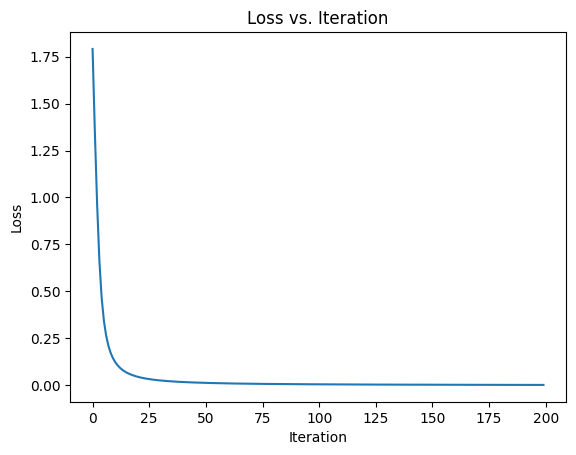

In [116]:
plot_losses(losses)

### Build same model with pyTorch 

In [256]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.3929880857467651
Epoch 10 loss: 0.5470646619796753
Epoch 20 loss: 0.029225585982203484
Epoch 30 loss: 0.00032999442191794515

Prediction:
tensor([[ 0.9997],
        [-0.9972]])
Loss: 5.966068783891387e-06


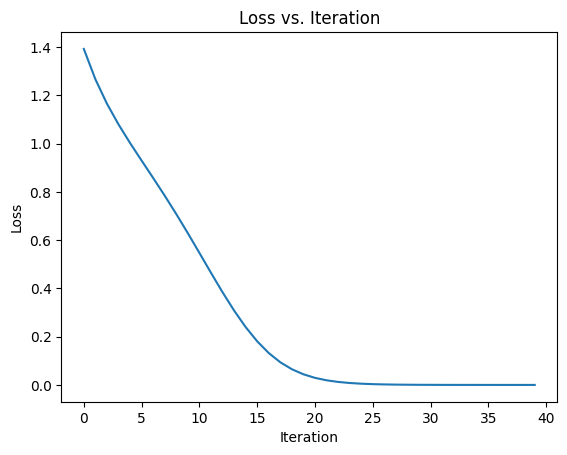

In [257]:
plot_losses(losses)

In [258]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")    

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[-0.1882,  0.3384,  0.2550],
        [-0.0109,  0.4958, -0.3400],
        [-0.0938,  0.3915, -0.4917],
        [-0.2361,  0.1854, -0.2138]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[ 0.3840, -0.7755],
        [ 1.8058, -0.6984],
        [ 1.4786, -0.9187],
        [ 0.2978, -1.0005]])

bT,  torch.Size([4, 1]):
tensor([[ 0.2877],
        [-0.5690],
        [ 0.1038],
        [-0.4864]])

w * input + bT,  torch.Size([4, 2]):
tensor([[ 0.6717, -0.4878],
        [ 1.2368, -1.2675],
        [ 1.5824, -0.8149],
        [-0.1886, -1.4869]])

output,  torch.Size([4, 2]):
tensor([[ 0.5861, -0.4524],
        [ 0.8445, -0.8531],
        [ 0.9190, -0.6723],
        [-0.1864, -0.9028]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[ 0.1463,  0.326

In [259]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [265]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9997, -0.9972]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(7.7079e-06)

In [271]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9997, -0.9972]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0003,  0.0028]])
squared_difference: tensor([[1.1173e-07, 7.5962e-06]])


tensor(3.8540e-06)

In [269]:
difference
len(squared_difference)

1

In [261]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(3.8540e-06)

In [262]:
torch.sum((output - torch.tensor(ys))**2)

tensor(7.7079e-06)